**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#importing Keras libraries
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from glob import glob
from tensorflow.keras.regularizers import l2

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Pointing to base path for train and test data set
base_path = 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/'

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(base_path + 'Train')
data_dir_test = pathlib.Path(base_path + 'Test')

In [5]:
print(data_dir_train)
print(data_dir_test)

gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train
gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

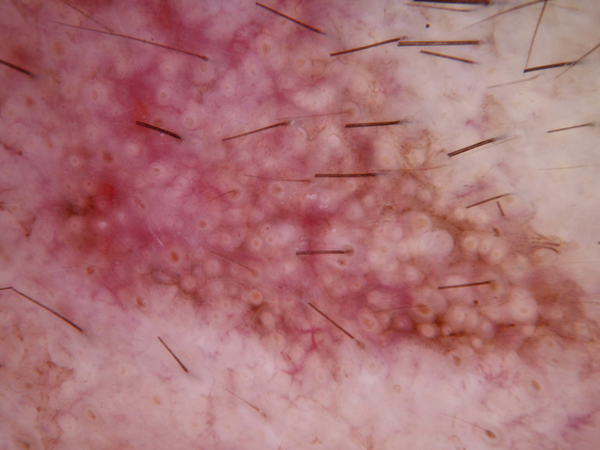

In [8]:
# Let's visualize one image first, to verify it is working or not.

actinic_keratosis = list(data_dir_train.glob('actinic keratosis/*'))
PIL.Image.open(str(actinic_keratosis[0]))

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset="training",
                                                               image_size=(img_height,img_width),
                                                               seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset="validation",
                                                               image_size=(img_height,img_width),
                                                               seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

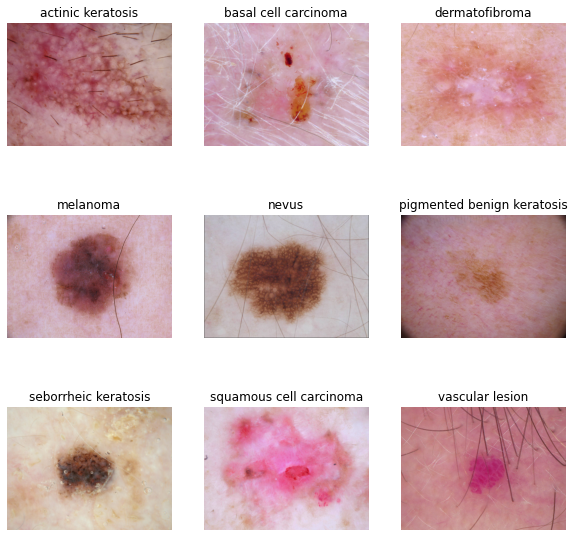

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
  ax = plt.subplot(3, 3, i + 1)
  image_list = list(data_dir_train.glob(class_names[i] + '/*.jpg'))
  plt.imshow(mpimg.imread(image_list[0]))                    # Displaying one instance of all 9 classes.
  plt.title(class_names[i])
  plt.axis("off")

plt.show()

In [13]:
# Let's iterate over the train dataset and retrieve batches of images and lables and verify

for image_batch, labels_batch in train_ds:
  print("image_batch: ", image_batch.shape)
  print("labels_batch: ", labels_batch.shape)
  break

image_batch:  (32, 180, 180, 3)
labels_batch:  (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

<font color="maroon">Let's now build the CNN architecture. For the Melanoma dataset, we do not need to build a very sophisticated CNN - a simple shallow-ish CNN would suffice for now.</font>

<font color="maroon">We will build a network with:</font>

- <font color="maroon">Two convolutional layers having 32 and 64 filters respectively,
- Followed by a max pooling layer,
- and then Flatten the output of the pooling layer to give us a long vector,
- then add a fully connected Dense layer with 128 neurons, and finally
- add a softmax layer with 9 neurons

The generic way to build a model in Keras is to instantiate a Sequential model and keep adding keras.layers to it.</font>

In [15]:
### Your code goes here
# model architecture
num_classes = len(class_names)

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# first convolutional layer
model.add(Conv2D(32, kernel_size= (3, 3), activation='relu'))

# second convolutional layer
model.add(Conv2D(64, kernel_size= (3, 3), activation='relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the pooling layer to give us a long vector and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
# As activation function used in last model is softmax due to which logits is set to false
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 495616)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               63438976  
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 186s 749ms/step - loss: 4.5559 - accuracy: 0.3052 - val_loss: 1.5782 - val_accuracy: 0.4452
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4952 - accuracy: 0.4771 - val_loss: 1.5396 - val_accuracy: 0.4810
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.3520 - accuracy: 0.5430 - val_loss: 1.4420 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.1533 - accuracy: 0.6060 - val_loss: 1.5442 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 2s 37ms/step - loss: 0.9893 - accuracy: 0.6551 - val_loss: 1.6286 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: 0.8117 - accuracy: 0.7182 - val_loss: 1.7203 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 2s 37ms/step - loss: 0.6967 - accuracy: 0.7556 - val_loss: 1.8681 - val_accuracy: 0.4944
Epoch 8/20

### Visualizing training results

Training Accuracy:  93.81
Validation Accuracy:  54.14


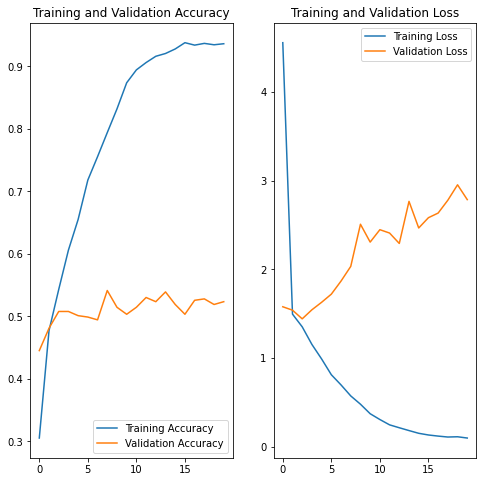

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Display Maximum Training Accuracy
print("Training Accuracy: ", round(max(acc)*100,2))
#Display Maximum Validation Accuracy
print("Validation Accuracy: ", round(max(val_acc)*100,2))

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Observation:**
<font color='maroon'>
**1.** In the plots above, the training accuracy is increasing linearly over the period of time and reaches around **93%**, whereas validation accuracy stalls around **54%** in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable which is a sign of **Overfitting**.

**2.** When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as **Overfitting**. It means that the model will have a difficult time generalizing on a new dataset.</font>

**There are multiple ways to fight overfitting in the training process.**
- Data augmentation
- Dropouts

## Data augmentation
Data augmentation takes the approach of generating additional training data from our existing examples by augmenting them using random transformations that yield believable looking images. This helps expose the model to more aspects of the data and generalize better.

## Dropout
Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When we apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# We will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing.
# These can be included inside our model like other layers, and run on the GPU.

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

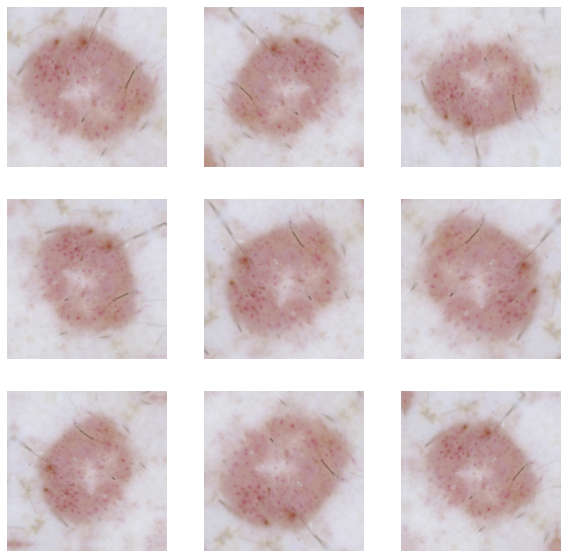

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
  for i in range(9):
    augmented_img = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_img[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# We will use data augmentation to train a model in a moment. Let's create a new neural network using layers.Dropout, then train it using augmented images.

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [23]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   )   ## your training code

Epoch 1/20
56/56 [==============================] - 2s 20ms/step - loss: 2.1006 - accuracy: 0.2478 - val_loss: 1.7876 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 1s 16ms/step - loss: 1.6486 - accuracy: 0.4141 - val_loss: 1.5885 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 1s 17ms/step - loss: 1.5344 - accuracy: 0.4593 - val_loss: 1.4704 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 1s 17ms/step - loss: 1.4323 - accuracy: 0.4877 - val_loss: 1.4701 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 1s 17ms/step - loss: 1.3744 - accuracy: 0.5156 - val_loss: 1.4560 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 1s 17ms/step - loss: 1.3518 - accuracy: 0.5184 - val_loss: 1.4112 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 17ms/step - loss: 1.2847 - accuracy: 0.5441 - val_loss: 1.3797 - val_accuracy: 0.5011
Epoch 8/20
56

### Visualizing the results

Training Accuracy:  58.54
Validation Accuracy:  56.6


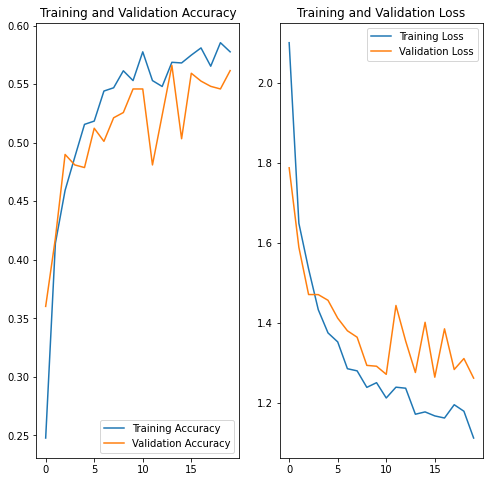

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Display Maximum Training Accuracy
print("Training Accuracy: ", round(max(acc)*100,2))
#Display Maximum Validation Accuracy
print("Validation Accuracy: ", round(max(val_acc)*100,2))

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observation:** 
<font color="maroon">After applying data augmentation and dropouts regularization, there is not much difference between the training and validation accuracy. Training accuracy is coming aroung **57%** while validation accuracy is coming around **56%**. Hence the model is not overfitted but still the model accuracy is not good or satisfied.</font>

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.

#Let's check class-imbalance and then take necessary action.

for i in class_names:
  sample_count = len(list(data_dir_train.glob(i + '/*.jpg')))
  print(str(i) + " class contains around: " + str(sample_count) + " sample count.")

actinic keratosis class contains around: 114 sample count.
basal cell carcinoma class contains around: 376 sample count.
dermatofibroma class contains around: 95 sample count.
melanoma class contains around: 438 sample count.
nevus class contains around: 357 sample count.
pigmented benign keratosis class contains around: 462 sample count.
seborrheic keratosis class contains around: 77 sample count.
squamous cell carcinoma class contains around: 181 sample count.
vascular lesion class contains around: 139 sample count.


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
**Answer:** <font color="maroon">**seborrheic keratosis** has the least number of samples around **77**.</font>

#### - Which classes dominate the data in terms proportionate number of samples?
**Answer:** <font color="maroon">**pigmented benign keratosis** class contains around **462** count due to which it dominate the data in terms of proportionate number of samples.</font>

Hence to rectify the above class imbalance we will use Augmentor package.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

## Augmentor:

Augmentor is a Python package designed to aid the augmentation and artificial generation of image data for machine learning tasks. It is primarily a data augmentation tool, but will also incorporate basic image pre-processing functionality.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset=str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFB6183A0D0>: 100%|██████████| 500/500 [00:10<00:00, 48.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFB618B1890>: 100%|██████████| 500/500 [00:10<00:00, 49.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFB61893110>: 100%|██████████| 500/500 [00:10<00:00, 48.88 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFB6199B250>: 100%|██████████| 500/500 [00:50<00:00,  9.88 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFB6183A7D0>: 100%|██████████| 500/500 [00:51<00:00,  9.74 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFB618D5750>: 100%|██████████| 500/500 [00:10<00:00, 47.85 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFBE01486D0>: 100%|██████████| 500/500 [00:23<00:00, 21.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFBE022FED0>: 100%|██████████| 500/500 [00:10<00:00, 47.23 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFB61F14910>: 100%|██████████| 500/500 [00:10<00:00, 47.99 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

**Original Training DataFrame**

In [31]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/ISIC_0025780.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/ISIC_0025803.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/ISIC_0025825.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/ISIC_0025953.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/ISIC_0025957.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/ISIC_0025992.jpg',
 'gdrive/My Drive/Cola

In [32]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [34]:
original_df.shape

(2239, 2)

**Augmented Training DataFrame after adding new images to the original training data.**

In [35]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_e6dd46d3-d2ef-4082-91f8-f580999ed0b4.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_8c00c9d1-d284-4f49-afad-7cdb1a6d2d3c.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_3ff963e0-20aa-4001-ad7e-971c49044259.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_2b69fc26-3e30-4f65-9676-caf5437c4287.jpg',
 'gdrive/My Drive/Colab Notebooks/Melanoma_CNN_a

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [39]:
df2.shape

(4500, 2)

In [40]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images if we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
#path to directory with training data + data created using augmentor
data_dir_train=data_dir_train

## Todo choose the correct parameter value, so that only training data is refered to,,
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
## Todo choose the correct parameter value, so that only validation data is refered to,

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [48]:
## your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.BatchNormalization(),

  # 1st Convolution Layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # 2nd Convolution Layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # 3rd Convolution Layer
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # 4th Convolution Layer
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # 5th Convolution Layer
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # FC layer
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

In [49]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 180, 180, 3)       12        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_7 (Batch (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 90, 90, 16)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [51]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   )   ## your training code

Epoch 1/30
169/169 [==============================] - 24s 128ms/step - loss: 2.4500 - accuracy: 0.2817 - val_loss: 2.9845 - val_accuracy: 0.1173
Epoch 2/30
169/169 [==============================] - 22s 126ms/step - loss: 1.7622 - accuracy: 0.3361 - val_loss: 3.4248 - val_accuracy: 0.1537
Epoch 3/30
169/169 [==============================] - 22s 127ms/step - loss: 1.6384 - accuracy: 0.3832 - val_loss: 1.5134 - val_accuracy: 0.4306
Epoch 4/30
169/169 [==============================] - 22s 126ms/step - loss: 1.5646 - accuracy: 0.4036 - val_loss: 1.4089 - val_accuracy: 0.4722
Epoch 5/30
169/169 [==============================] - 22s 126ms/step - loss: 1.5019 - accuracy: 0.4243 - val_loss: 1.5736 - val_accuracy: 0.4001
Epoch 6/30
169/169 [==============================] - 22s 125ms/step - loss: 1.5067 - accuracy: 0.4234 - val_loss: 1.2816 - val_accuracy: 0.4937
Epoch 7/30
169/169 [==============================] - 22s 127ms/step - loss: 1.4443 - accuracy: 0.4390 - val_loss: 1.2684 - val_ac

#### **Todo:**  Visualize the model results

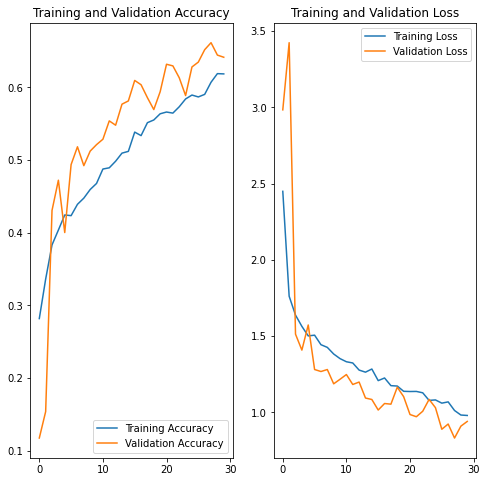

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?




- <font color="green"> Yes, class rebalance helps which result model's training and validation accuracy increased around **61%** after increasing the sample size (augmentation) and introducing Batch Normalisation and Dropout. However there is no sign of overfitting but accuracy is low which could be increased by increasing epochs and convolution layers. </br>
- Introducing Batch normalization smoothens the loss function that in turn by optimizing the model parameters improves the training speed of the model.</font>